# The online food store user behavior

**Description of the project**

For a startup - an online grocery store, you need to figure out how users of a mobile application behave.

Project objective:
1. Study the sales funnel: understand how and how many users reach the purchase. And how much - "gets stuck" on the previous steps, and on which ones.
2. Explore the results of an A/A/B experiment: the impact of changing the font in the application on user behavior.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Project Structure**
1. Data Acquaintance<br/>
2. Data preprocessing<br/>
3. Exploratory data analysis<br/>
4. Exploration of  the funnel of events<br/>
5.1. Analysis of A/A Experiment <br/>
5.2. Analysis of A/B Experiment<br/>
6. Conclusions

## Data Acquaintance

*Let's call the libraries we need*

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats as st
import math as mt
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings
from matplotlib.pyplot import figure

*read the dataset*

In [3]:
try:
     data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
except:
     data = pd.read_csv('/content/drive/MyDrive/dataf/logs_exp.csv',  sep = '\t')

In [4]:
data.head(20)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


**Dataframe content**<br/>

EventName — event name;<br/>
DeviceIDHash - unique user ID;<br/>
EventTimestamp — event time;<br/>
ExpId  -  the number of the experiment: 246 and 247 are the control groups, and 248 is the experimental group.<br/>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


<div style="border:solid green 2px; padding: 20px">
    
**Conclusions:**
The data contains 244126 rows, and there are no gaps in the data, but the columns need to be renamed because they have capital letters, and need to be checked for duplicates. Dates and times need to be converted to DateTime format.

## Data preprocessing

### Let's rename the columns first



In [6]:
data.columns = data.columns.str.lower()

In [7]:
data.columns

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')

In [8]:
data.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

In [9]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


*Columns are reduced to snake register*

### Casting data to the desired data type

*Let's create columns with time and date*

In [10]:
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['date_time'].astype('datetime64[D]')

In [11]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


###Checking for duplicates

In [12]:
print('Number of duplicates in data {}'.format(data.duplicated().sum()))

Number of duplicates in data 413


In [13]:
data[data.duplicated()].head(20)

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3573,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
4076,MainScreenAppear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4803,MainScreenAppear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01
5641,CartScreenAppear,4248762472840564256,1564637764,248,2019-08-01 05:36:04,2019-08-01
5875,PaymentScreenSuccessful,6427012997733591237,1564638452,248,2019-08-01 05:47:32,2019-08-01
7249,OffersScreenAppear,7224691986599895551,1564641846,246,2019-08-01 06:44:06,2019-08-01
8065,CartScreenAppear,8189122927585332969,1564643929,248,2019-08-01 07:18:49,2019-08-01
9179,MainScreenAppear,2230705996155527339,1564646087,246,2019-08-01 07:54:47,2019-08-01


*Let's get rid of duplicates*

In [14]:
data = data.drop_duplicates()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


<div style="border:solid green 2px; padding: 20px">

**Conclusions:**

Removed 413 duplicates, renamed columns, converted dates and times in new columns to datetime format.

## Exploratory data analysis

*We will consider the number and names of events in the dataframe*

In [16]:
print('Number of events in the data frame: {}'.format( data['event_name'].nunique()))

Number of events in the data frame: 5


In [17]:
print('List of events in the data frame: {}'.format( data['event_name'].unique()))

List of events in the data frame: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


*List of events*
- MainScreenAppear - the user has entered the main screen
- OffersScreenAppear - the user has entered the purchase screen
- CartScreenAppear - the user has entered the cart screen
- PaymentScreenSuccessful - the user has paid for the item
- Tutorial - the user has entered the "user's guide" section

*Get the number of unique users*


In [18]:
print('Number of unique users in the data frame: {}'.format(data['device_id_hash'].nunique()))

Number of unique users in the data frame: 7551


*We will find out the number of events committed by users, for this we group and display the largest number of events per user*

In [19]:
group_event = data.groupby('device_id_hash')['event_name'].count().reset_index()

In [20]:
group_event.sort_values(by='event_name', ascending=False).head(10)

,device_id_hash,event_name
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
2641,3337471580007169353,1186
6294,7738058666231999878,888
822,1055544042902443290,854
3801,4713748699910253089,824
6617,8118046800480174342,755


*Let's consider the received data frame, from the point of view of statistics*

In [21]:
group_event['event_name'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

*Each user has an average of 32 events, while half of the users have no more than 20 events, 75% of users do not commit more than 37 events*

*Let's study the period of observations and our experiment* 

In [22]:
print('A/A/B test started at {}'.format(data['date'].min())),
print('A/A/B  test finished at {}'.format(data['date'].max())),
print('A/A/B test lasts {}'.format(data['date'].max() - data['date'].min()))

A/A/B test started at 2019-07-25 00:00:00
A/A/B  test finished at 2019-08-07 00:00:00
A/A/B test lasts 13 days 00:00:00


*Let's plot a histogram of the distribution of events:*

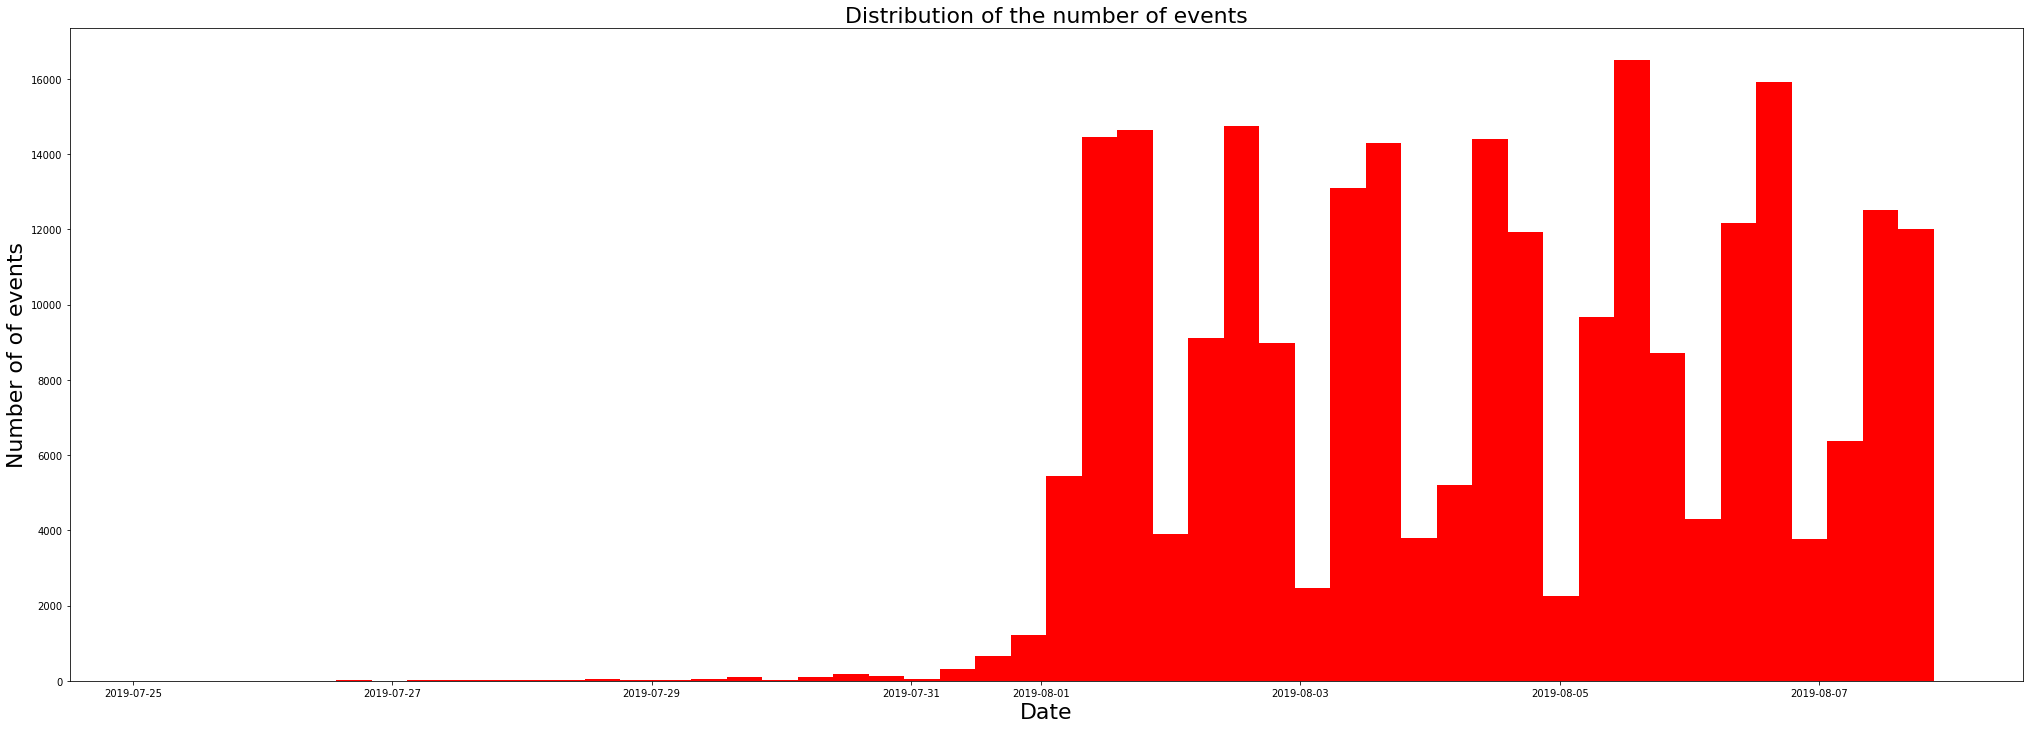

In [23]:
fig = plt.figure()
fig.set_figwidth(35)
fig.set_figheight(12)
ax = fig.add_subplot(1, 1, 1)
plt.hist(data['date_time'], color = 'Red', bins = 50)
plt.xlabel('Date', fontsize = 22, color = 'Black')
plt.ylabel('Number of of events', fontsize = 22, color = 'Black')
plt.title('Distribution of the number of events',fontsize = 22, color = 'Black');

*Technically, in the logs of new days for some users, events from the past can “reach” - this can “skew the data”. The main data array accumulates after August 01, and it is most likely worth getting rid of the data before this date to get rid of distortions.*

In [24]:
data = data[data['date_time']>='2019-08-01']

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   exp_id           240887 non-null  int64         
 4   date_time        240887 non-null  datetime64[ns]
 5   date             240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


*In total, by now we have gotten rid of 1.2% of the sample, but at the same time, we got cleaner data.*

*Next, let's consider the homogeneity of groups, group the number of users into groups*

In [26]:
group_amount = data.groupby('exp_id')['device_id_hash'].nunique().reset_index()
group_amount

,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


*Let's consider the difference between the largest and smallest group*

In [27]:
print('Difference between largest 248 group and smallest 246 group is {} %'.format(
    (data[data['exp_id']==248]['device_id_hash'].nunique() - data[data['exp_id']==246]['device_id_hash'].nunique())*100/ data[data['exp_id']==248]['device_id_hash'].nunique()))

Difference between largest 248 group and smallest 246 group is 2.0890815924320063 %


*The difference between the groups is quite significant, as far as we have enough data to consider the experiment successful, we will consider further, let's see the intersections between the groups*

In [28]:
users_246 = data [data['exp_id'] == 246]['device_id_hash'].unique()
users_247 = data [data['exp_id'] == 247]['device_id_hash'].unique()
users_248 = data [data['exp_id'] == 248]['device_id_hash'].unique()



In [29]:
common_246_247 = len(list(set(users_246).intersection(set(users_247))))
common_247_248 = len(list(set(users_247).intersection(set(users_248))))
common_246_248 = len(list(set(users_246).intersection(set(users_248))))

In [30]:
print('Intersections between each two groups of three are: 246 and 247 - {}; 247 and 248 - {}; 246 and 248 - {}'.format(common_246_247, common_247_248, common_246_248)) 

Intersections between each two groups of three are: 246 and 247 - 0; 247 and 248 - 0; 246 and 248 - 0


*There were no intersections in the samples, which means they are homogeneous. We will keep in mind the difference in the number of unique users between groups*

<div style="border:solid green 2px; padding: 20px">
    
**Conclusions:**
We identified the main events and calculated the number of events per user - 32 events, while 75% of users do not take more than 37 actions.<br/>
We chose the cleanest period of the experiment (starting from August 1) and got rid of the data that could introduce a bias.<br/>
We also looked at the data by groups and found that they do not overlap.<br/>
Next, consider the funnel of events and how users behave at different stages.    
    

## Explore the funnel of events

*Once again, we will group the data for each of the events and sort them in descending order*

In [31]:
event_group = data.groupby('event_name')['device_id_hash'].count().reset_index().sort_values(by='device_id_hash', ascending=False)

In [32]:
cm = sns.light_palette("green", as_cmap=True)

event_group.style.background_gradient(cmap=cm)

,event_name,device_id_hash
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


*Let's add a column with the share of users from the total number of users who made each event*

In [33]:
event_group['part_of_events'] = event_group['device_id_hash']*100/ len (data['event_name'])


In [34]:
event_group_users = data.groupby('event_name')['device_id_hash'].nunique().reset_index().sort_values(by='device_id_hash', ascending =False)
event_group_users

,event_name,device_id_hash
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [35]:
event_group_users ['part_of_users']=event_group_users ['device_id_hash']*100/ data['device_id_hash'].nunique()
event_group_users

,event_name,device_id_hash,part_of_users
1,MainScreenAppear,7419,98.473586
2,OffersScreenAppear,4593,60.963632
0,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


In [36]:
event_group = event_group.merge(event_group_users, on='event_name', how='left')
event_group

,event_name,device_id_hash_x,part_of_events,device_id_hash_y,part_of_users
0,MainScreenAppear,117328,48.706655,7419,98.473586
1,OffersScreenAppear,46333,19.234330,4593,60.963632
2,CartScreenAppear,42303,17.561346,3734,49.561986
3,PaymentScreenSuccessful,33918,14.080461,3539,46.973719
4,Tutorial,1005,0.417208,840,11.149456


In [37]:
event_group.columns = ['event_name','device_id_hash','part_of_events', 'device_id_hash_unq','part_of_users']

In [38]:
cm = sns.light_palette("green", as_cmap=True)

event_group.style.background_gradient(cmap=cm)

,event_name,device_id_hash,part_of_events,device_id_hash_unq,part_of_users
0,MainScreenAppear,117328,48.706655,7419,98.473586
1,OffersScreenAppear,46333,19.234330,4593,60.963632
2,CartScreenAppear,42303,17.561346,3734,49.561986
3,PaymentScreenSuccessful,33918,14.080461,3539,46.973719
4,Tutorial,1005,0.417208,840,11.149456


*Thus, the following funnel of events is built: main screen > order screen > cart > payment. Separately, there is the "user guide" action, which most likely will not affect the economy of the application in any way, and makes up only 0.4% of all user actions and 11% of users used it, so we will also remove it*


In [39]:
data = data[data['event_name']!='Tutorial'].copy()
event_group = event_group[event_group['event_name']!='Tutorial'].copy()

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239882 entries, 2829 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       239882 non-null  object        
 1   device_id_hash   239882 non-null  int64         
 2   event_timestamp  239882 non-null  int64         
 3   exp_id           239882 non-null  int64         
 4   date_time        239882 non-null  datetime64[ns]
 5   date             239882 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.8+ MB


*At the moment, we got rid of 1.7% of the data from the original dataframe*

*Once again, we will group the resulting data, and add a column with a step conversion for each stage, as well as calculate the total conversion from the main screen to the successful payment screen*

In [41]:
cm = sns.light_palette("green", as_cmap=True)

event_group.style.background_gradient(cmap=cm)


,event_name,device_id_hash,part_of_events,device_id_hash_unq,part_of_users
0,MainScreenAppear,117328,48.706655,7419,98.473586
1,OffersScreenAppear,46333,19.234330,4593,60.963632
2,CartScreenAppear,42303,17.561346,3734,49.561986
3,PaymentScreenSuccessful,33918,14.080461,3539,46.973719


In [42]:
conversion_1 = data[data['event_name']=='OffersScreenAppear']['device_id_hash'].nunique()/data[data['event_name']=='MainScreenAppear']['device_id_hash'].nunique()

In [43]:
conversion_2 = data[data['event_name']=='CartScreenAppear']['device_id_hash'].nunique()/data[data['event_name']=='OffersScreenAppear']['device_id_hash'].nunique()

In [44]:
conversion_3 = data[data['event_name']=='PaymentScreenSuccessful']['device_id_hash'].nunique()/data[data['event_name']=='CartScreenAppear']['device_id_hash'].nunique()

In [45]:
total_conversion = data[data['event_name']=='PaymentScreenSuccessful']['device_id_hash'].nunique() /data[data['event_name']=='MainScreenAppear']['device_id_hash'].nunique()

In [46]:
event_group['conversion'] = [0, conversion_1,conversion_2,conversion_3]

In [47]:
cm = sns.light_palette("green", as_cmap=True)

event_group.style.background_gradient(cmap=cm)

,event_name,device_id_hash,part_of_events,device_id_hash_unq,part_of_users,conversion
0,MainScreenAppear,117328,48.706655,7419,98.473586,0.000000
1,OffersScreenAppear,46333,19.234330,4593,60.963632,0.619086
2,CartScreenAppear,42303,17.561346,3734,49.561986,0.812976
3,PaymentScreenSuccessful,33918,14.080461,3539,46.973719,0.947777


In [48]:
print('Total conversion from first screen to payment is {} %'.format(round(total_conversion*100,2)))

Total conversion from first screen to payment is 47.7 %


*Let's plot a graph of user losses at each stage*

In [49]:
event_group['lost_users'] = 1 - event_group[event_group['event_name']!='MainScreenAppear']['conversion']

In [50]:
event_group.fillna(0)

,event_name,device_id_hash,part_of_events,device_id_hash_unq,part_of_users,conversion,lost_users
0,MainScreenAppear,117328,48.706655,7419,98.473586,0.000000,0.000000
1,OffersScreenAppear,46333,19.234330,4593,60.963632,0.619086,0.380914
2,CartScreenAppear,42303,17.561346,3734,49.561986,0.812976,0.187024
3,PaymentScreenSuccessful,33918,14.080461,3539,46.973719,0.947777,0.052223


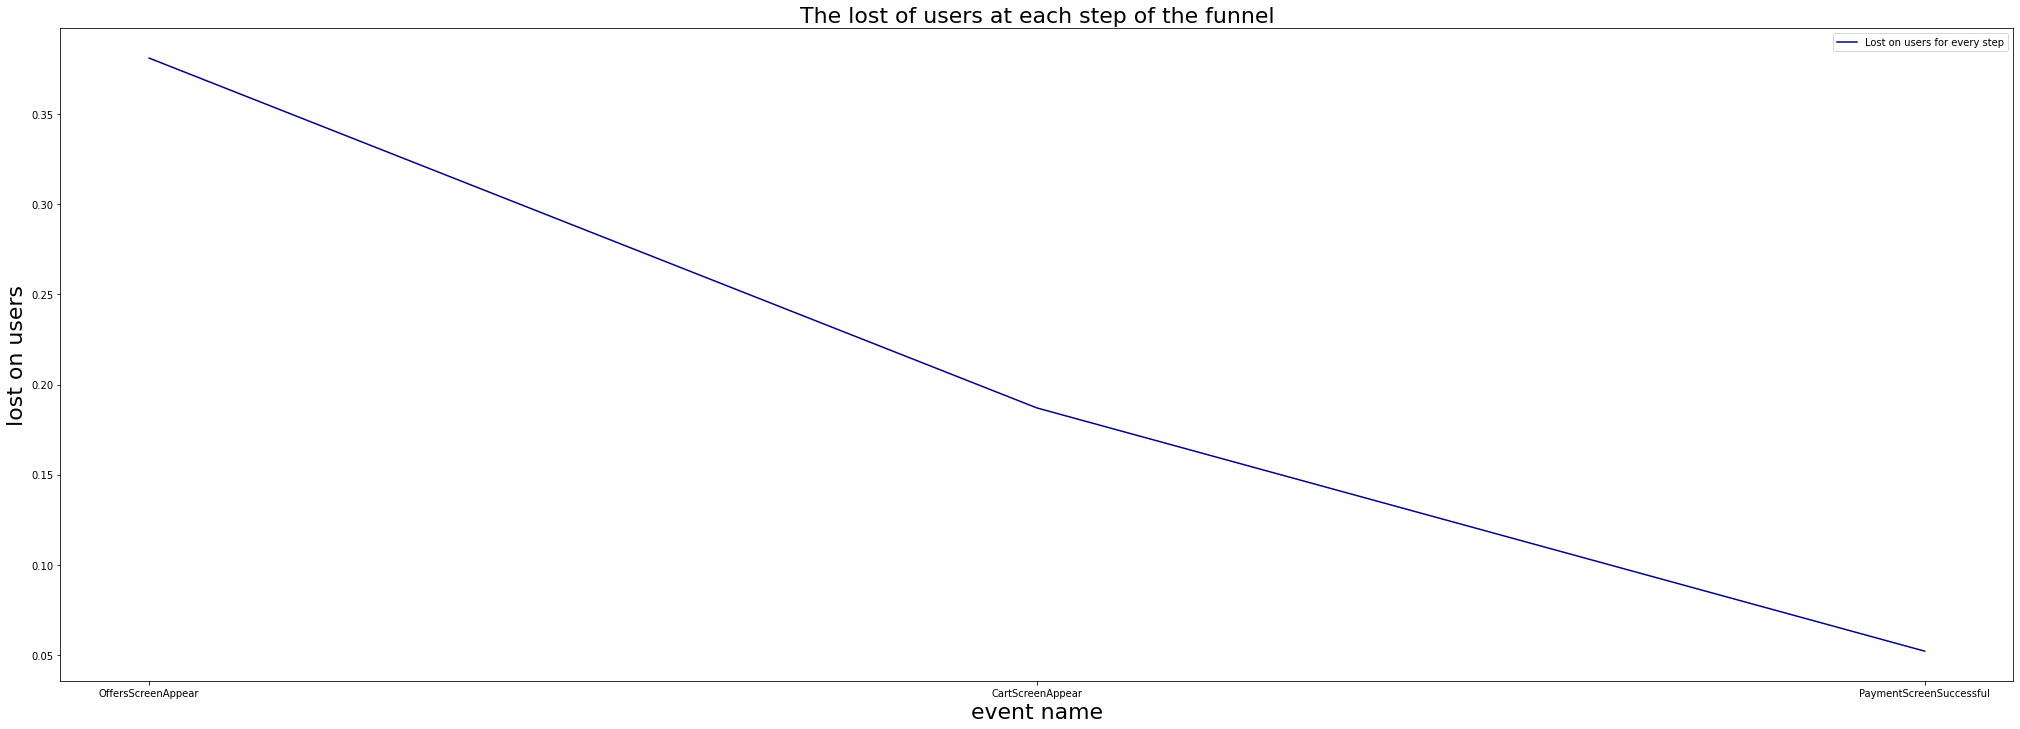

In [51]:
fig = plt.figure()
fig.set_figwidth(35)
fig.set_figheight(12)
ax = fig.add_subplot(1, 1, 1)
plt.plot(event_group['event_name'],event_group['lost_users'], label="Lost on users for every step", color = 'Darkblue')
plt.legend()
plt.xlabel('event name', fontsize = 22, color = 'Black')
plt.ylabel('lost on users', fontsize = 22, color = 'Black')
plt.title('The lost of users at each step of the funnel',fontsize = 22, color = 'Black');

*As we can see from the graph, the biggest loss of users occurs on the transition screen from the home screen to purchases.*


    
*Let's display a graphical representation of the funnel of events by users*


In [52]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = event_group ['event_name'],
    x = event_group ['device_id_hash_unq'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 2, 2, 3], "color": ["wheat", "wheat", "blue", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}),
   layout_title_text= 'The event funnel in the app')

fig.show()

<div style="border:solid green 2px; padding: 20px">
    
**Conclusions:**<br/>
The funnel of events in the application looks like this: main screen > order screen > cart > payment; a separate event is viewing the user manual<br/>
Only 62% of users go to product pages from the main screen, it is at this step that the most users are lost (38%) <br/> The peak of conversion between steps falls on the purchase step, that is, 94% of users who put the product in the cart pay for it < br/>
The total conversion from users to buyers is about 47.7%
Next, we will study the results of the experiment   
    

## Experiment Results

*Once again we will derive the groups with their amount*

In [53]:
group_amount

,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


### Difference in Control Groups

*Let's check for statistical differences between the samples in the control groups 246 and 247*

*First, let's collect two common samples from these groups:
Hypothesis testing about comparing the means of two control groups:*
```
H_0: Mean in  groups 246 and 247 are equal

H_a: Mean in groups 246 and 247 are different
alpha = 0.05
```

In [54]:
sample_a1 = data[data['exp_id']==246].groupby('device_id_hash').agg({'event_name':'count'})
sample_a2 = data[data['exp_id']==247].groupby('device_id_hash').agg({'event_name':'count'})
alpha = .05 
results = st.ttest_ind(
    sample_a1, 
    sample_a2)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis") 

p-value: [0.45545715]
Failed to reject the null hypothesis


*There was no statistical difference between the samples of the control groups*

### Writing a Function to Calculate an Experiment

*Since we are going to compare the shares of users who have moved to the next step in the funnel, we will use the z-criterion, to compare both control groups and the test group with each other, we will write a function*

In [55]:
def z_test (group_1, group_2, event):
    sample_a1 = data[data['exp_id']==group_1]['device_id_hash'].nunique()
    sample_a1_ev = data[(data['exp_id']==group_1)&(data['event_name']==event)]['device_id_hash'].nunique()
    sample_a2 = data[data['exp_id']==group_2]['device_id_hash'].nunique()
    sample_a2_ev = data[(data['exp_id']==group_2)&(data['event_name']==event)]['device_id_hash'].nunique()
    alpha = 0.05 


    p1 = sample_a1_ev/sample_a1
    p2 = sample_a2_ev/sample_a2

    p_combined = (sample_a1_ev + sample_a2_ev)/ (sample_a1 + sample_a2)


    difference = p1 - p2 
    z_value = difference / mt.sqrt(p_combined * (1 - p_combined) * (1/sample_a1 + 1/sample_a2))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the proportions')
    else:
        print(
             'We failed to reject the null hypothesis, there is no reason to consider the proportions different'
    )
    

### Hypothesis testing between control groups

```
H_0: The proportions of groups 246 and 247 when entering the main screen are equal

H_a: The proportions of groups 246 and 247 when entering the main screen are different
alpha = 0.05
```

In [56]:
z_test (246, 247, 'MainScreenAppear')

p-value:  0.7526703436483038
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups 246 and 247 when entering the shopping screen from the main screen are equal

H_a: The proportions  of groups 246 and 247 when entering the shopping screen from the main screen are different
alpha = 0.05
```

In [57]:
z_test (246, 247, 'OffersScreenAppear')

p-value:  0.24786096925282264
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups 246 and 247 when entering the shopping cart screen from the shopping screen are equal

H_a: The proportions  of groups 246 and 247 when entering the shopping cart screen from the shopping screen are different
alpha = 0.05
```

In [58]:
z_test (246, 247, 'CartScreenAppear')

p-value:  0.22867643757335676
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups 246 and 247 when entering the order payment screen from the shopping screen are equal

H_a: The proportions of groups 246 and 247 when entering the order payment screen from the shopping screen are different
alpha = 0.05
```

In [59]:
z_test (246, 247, 'PaymentScreenSuccessful')

p-value:  0.11446627829276612
We failed to reject the null hypothesis, there is no reason to consider the proportions different


<div style="border:solid green 2px; padding: 20px">
    
**Conclusions:**<br/>
No statistical differences were found between the control groups.
    

### Checking the difference in proportions between control and test group

*Next, we will check the statistical difference in the proportions between the control and the test group*

```
H_0: The proportions of groups 246 and 248 when entering the main screen are equal

H_a: The proportions  of groups 246 and 248 differ when entering the main screen
alpha = 0.05
```

In [60]:
z_test (246, 248, 'MainScreenAppear')

p-value:  0.3387114076159288
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups 246 and 248 when entering the shopping screen from the main screen are equal

H_a: The proportions  of groups 246 and 248 p when entering the shopping screen from the main screen are different
alpha = 0.05
```

In [61]:
z_test (246, 248, 'OffersScreenAppear')

p-value:  0.21442476639710506
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups 246 and 248 when entering the shopping cart screen from the shopping screen are equal

H_a: The proportions of groups 246 and 248 p when entering the shopping cart screen from the shopping screen are different
alpha = 0.05
```

In [62]:
z_test (246, 248, 'CartScreenAppear')

p-value:  0.08067367598823139
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions  of groups 246 and 248 when entering the order payment screen from the shopping screen are equal

H_a: The proportions   of groups 246 and 248 when entering the order payment screen from the shopping screen are different
alpha = 0.05
```   

In [63]:
z_test (246, 248, 'PaymentScreenSuccessful')

p-value:  0.21693033984516674
We failed to reject the null hypothesis, there is no reason to consider the proportions different


<div style="border:solid green 2px; padding: 20px">

**Conclusions:**<br/>
There were no statistical differences between the control group 246 and the test group 248.

```
H_0: The proportions of groups 247 and 248 when entering the main screen are equal

H_a: The proportions of groups 247 and 248 differ when entering the main screen
alpha = 0.05
```

In [64]:
z_test (248, 247, 'MainScreenAppear')

p-value:  0.5194964354051703
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups 247 and 248 when entering the shopping screen from the main screen are equal

H_a: The proportions of groups 247 and 248 when entering the shopping screen from the main screen are different
alpha = 0.05
```    

In [65]:
z_test (248, 247, 'OffersScreenAppear')

p-value:  0.9333751305879443
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups 247 and 248 when entering the shopping cart screen from the shopping screen are equal

H_a: The proportions  of groups 247 and 248 are different when entering the shopping cart screen from the shopping screen
alpha = 0.05
```

In [66]:
z_test (247, 248, 'CartScreenAppear')

p-value:  0.5878284605111943
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups 247 and 248 when entering the order payment screen from the shopping screen are equal

H_a: The proportions of groups 247 and 248 when entering the order payment screen from the shopping screen are different
alpha = 0.05
```

In [67]:
z_test (247, 248, 'PaymentScreenSuccessful')

p-value:  0.7275718682261119
We failed to reject the null hypothesis, there is no reason to consider the proportions different


<div style="border:solid green 2px; padding: 20px">
 
 **Conclusions:**<br/>
There were no statistical differences between the control group 247 and the test group 248.

*Next, we will consider the difference in proportions between the pooled control group and the test group. To do this, let's make a new function*

In [68]:
def z_test_comn (group_1, group_2, group_3, event):
    sample_a1 = data[data['exp_id']==group_1]['device_id_hash'].nunique() + data[data['exp_id']==group_2]['device_id_hash'].nunique()
    sample_a1_ev = data[(data['exp_id']==group_1)&(data['event_name']==event)]['device_id_hash'].nunique() + data[(data['exp_id']==group_2)&(data['event_name']==event)]['device_id_hash'].nunique()
    sample_a2 = data[data['exp_id']==group_3]['device_id_hash'].nunique()
    sample_a2_ev = data[(data['exp_id']==group_3)&(data['event_name']==event)]['device_id_hash'].nunique()
    alpha = 0.05 


    p1 = sample_a1_ev/sample_a1
    p2 = sample_a2_ev/sample_a2

    p_combined = (sample_a1_ev + sample_a2_ev)/ (sample_a1 + sample_a2)


    difference = p1 - p2 
    z_value = difference / mt.sqrt(p_combined * (1 - p_combined) * (1/sample_a1 + 1/sample_a2))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the proportions')
    else:
        print(
             'We failed to reject the null hypothesis, there is no reason to consider the proportions different'
    )

*Hypothesis testing with a pooled control group and test group* 

```
H_0: The proportions of groups in the combined control group and the 248 group when entering the main screen are equal

H_a: The proportions of groups in the combined control group and the 248 group when entering the main screen are different
alpha = 0.05
```

In [69]:
z_test_comn (246,247, 248, 'MainScreenAppear')

p-value:  0.3486684291093256
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups in the combined control group and the 248 group when entering the shopping screen from the main screen are equal

H_a: The proportions of groups in the combined control group and the 248 group when entering the shopping screen from the main screen are different
alpha = 0.05
```

In [70]:
z_test_comn (246,247, 248, 'OffersScreenAppear')

p-value:  0.44582745409482394
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups in the combined control group and the 248 group when entering the shopping cart screen from the shopping screen are equal

H_a: The proportions of groups in the combined control group and the 248 group when entering the shopping cart screen from the shopping screen are different
alpha = 0.05
```

In [71]:
z_test_comn (246,247, 248, 'CartScreenAppear')

p-value:  0.18683558686831558
We failed to reject the null hypothesis, there is no reason to consider the proportions different


```
H_0: The proportions of groups in the combined control group and the 248 group when entering the order payment screen from the shopping screen are equal

H_a: The proportions of the groups in the combined control group and the 248 group when entering the order payment screen from the shopping screen are different
alpha = 0.05
```   

In [72]:
z_test_comn (246,247, 248, 'PaymentScreenSuccessful')

p-value:  0.6107918742187335
We failed to reject the null hypothesis, there is no reason to consider the proportions different


<div style="border:solid green 2px; padding: 20px">
    
**Conclusions:**<br/>
There were no statistical differences between the pooled control group and the test group 248.

## General conclusion

<div style="border:solid pink 2px; padding: 20px">
    
 <br/>
1. We investigated the results of the A/A/B mobile application experiment conducted from July 25 to August 07, 2019 <br/>
2. Based on the data obtained as a result of the test, we described the behavior of users in the application, the following funnel of events is built: main screen>order screen>cart>payment. Separately, there is the "user guide" action, which most likely will not affect the economy of the application in any way.<br/>
3. Only 62% of users go to product pages from the main screen, it is at this step that the most users are lost (38%) <br/>
4. The peak of conversion between steps falls on the purchase step, that is, 94% of users who put the product in the cart pay for it. <br/>
5. The overall conversion from users to buyers is about 47.7%. <br/>
6. Testing for statistical differences between control groups showed no difference and uniformity.
7. No statistical difference in the behavior of the control and test groups was found.<br/>
8. Changing fonts in the application will not affect user behavior.